In [32]:
import os
import math
import torch
import zipfile
import random
import numpy as np
import urllib.request
import torch.nn as nn
import torch.utils.data
from pathlib import Path
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision import datasets, transforms

torch.manual_seed(0)

In [33]:
def mkDataSet(data_size, data_length=10, freq=60., noise=0.001):
    """
    params\n
    data_size : データセットサイズ\n
    data_length : 各データの時系列長\n
    freq : 周波数\n
    noise : ノイズの振幅\n
    returns\n
    train_x : トレーニングデータ（t=1,2,...,size-1の値)\n
    train_t : トレーニングデータのラベル（t=sizeの値）\n
    """
    train_x = []
    train_t = []

    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq) + np.random.normal(loc=1.0, scale=noise)] for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])
    
    train_x = np.array(train_x).astype(np.float32) #float.32に型変換必須
    train_t = np.array(train_t).astype(np.float32) #float.32に型変換必須

    return train_x, train_t

In [34]:

def mkRandomBatch(train_x, train_t, batch_size):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    return torch.tensor(batch_x), torch.tensor(batch_t)

In [35]:
#モデルの定義
class Predictor(nn.Module):
  def __init__(self, inputDim, hiddenDim, outputDim):
    super(Predictor, self).__init__()
    latent_features = 2
    self.hidden_dim = hiddenDim
    self.input_dim = inputDim
    self.rnn = nn.LSTM(input_size = inputDim,
                       hidden_size = hiddenDim,
                       batch_first = True)
    self.hidden2tag = nn.Linear(hiddenDim, outputDim)
    self.output_layer = nn.Linear(hiddenDim, outputDim)

    self.fc1 = nn.Linear(hiddenDim, latent_features)
    self.fc2 = nn.Linear(latent_features, hiddenDim)

    self.softmax = nn.LogSoftmax()
    self.tanh = nn.Tanh()
  
  def encode(self, inputs, hidden0 = None):
    output, (hidden, cell) = self.rnn(inputs, hidden0)
    hidden = hidden.view(-1, hidden.shape[2])
    h = self.fc1(hidden)
    return self.tanh(h)
  
  def decode(self, inputs, hidden0):
    output, (hidden, cell) = self.rnn(inputs, hidden0)
    return output

  def forward(self, inputs, hidden0 = None):
    h = self.encode(inputs)#encode
    hidden = self.fc2(h)#全結合
    hidden = hidden.view(1, -1, self.hidden_dim)
    cell = torch.zeros(hidden.shape)
    hidden0 = (hidden, cell)
    x = self.decode(inputs, hidden0)#decode
    output = self.output_layer(x[:, -1, :])
    return output, h


In [36]:
model = Predictor(1, 20, 1)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [53]:
hidden_size = 2
epochs_num = 300
input_range = 100
batch_size = 20
train_x, train_t = mkDataSet(input_range)
loss_list = []
h_list_x = []
h_list_y = []

In [54]:

for epoch in range(epochs_num):
  output_ = []
  for i in range(int(input_range / batch_size)):
    optimizer.zero_grad()
    data, label = mkRandomBatch(train_x, train_t, batch_size)
    output, h = model(data)
    output_.append(output[0])
    for i in h:
      h_list_x.append(i[0].detach().numpy())
      h_list_y.append(i[1].detach().numpy())

    loss = criterion(output, label)
    loss.backward()#誤差逆伝播
    optimizer.step()#誤差に基づきネットワークパラメータ更新
   
  

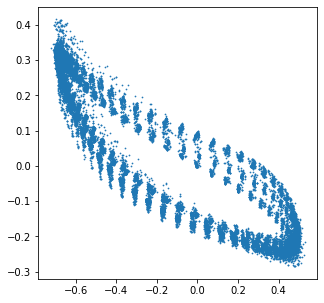

In [55]:
#AEの潜在空間潜在空間zの可視化
plt.figure(figsize = (5, 5))
plt.scatter(h_list_x, h_list_y, s = 0.5)